In [3]:
import cv2
import os, fnmatch
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import FeatureExtractor
from utils import SVC
from utils import get_feature
%matplotlib inline

In [4]:
# Get name
def get_file_names(src_path='./', pattern='*.jpeg'):
    # Return a list of file names in a given folder with certain pattern
    # images = glob.glob('../data/**.jpeg')
    images = []
    for root, dir_names, file_names in os.walk(src_path):
        for filename in fnmatch.filter(file_names, pattern):
            images.append(os.path.join(root, filename))
    return images

In [5]:
# Import car and not car images
cars = get_file_names('./data/vehicles', pattern='*.png')[0:1000]
not_cars = get_file_names('./data/non-vehicles', pattern='*.png')[0:1000]

In [6]:
# Calculate car features & not-car features
t = time.time()
print("Calculating features for {} images...".format(len(cars)+len(not_cars)))
car_features = get_feature(cars, workers=4)
not_car_features = get_feature(not_cars, workers=4)
print("Completed calculating feature in {:f} seconds\n".format((time.time() - t), 3))

Calculating features for 2000 images...
Average time / feature : 0.00676622414589 seconds
Average time / feature : 0.0068814060688 seconds
Completed calculating feature in 3.574504 seconds



In [7]:
# Create data set
x = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.concatenate((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print("Car Feature Vector's length: ", len(car_features))
print("Not Car Feature Vector's length: ", len(not_car_features))

("Car Feature Vector's length: ", 1000)
("Not Car Feature Vector's length: ", 1000)


In [8]:
# Training using SVC Classifier
svc = SVC(x, y, test_split=0.01)
svc.train()
svc.score()

Training data: Features 1800, Labels 1800
Test data: Features 200, Labels 200

Starting to train vehicle detection classifier.
Completed training in 0.356303 seconds.

Testing accuracy:
Accuracy 1.000000%


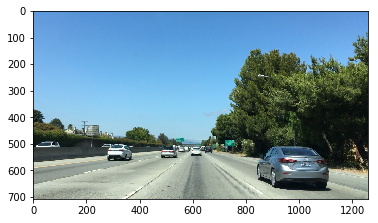

In [9]:
# Using an example 
test_img =cv2.cvtColor(cv2.imread('./bbox-example-image.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)


In [10]:
# Create a list of Windows
def create_windows(x_region=[None, None], y_region=[None, None], 
                  xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    if x_region[0] is None:
        x_region[0] = 0
    if x_region[1] is None:
        x_region[1] = 0
    if y_region[0] is None:
        y_region[0] = 0
    if y_region[1] is None:
        y_region[1] = 0
    # Compute the region of interest
    x = x_region[1] - x_region[0]
    y = y_region[1] - y_region[0]

    # Step size
    x_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))

    # Total windows
    x_windows = np.int(x/x_pix_per_step) - 1
    y_windows = np.int(y/y_pix_per_step) - 1

    windows = []
    for ys in range(y_windows):
        for xs in range(x_windows):
            # Calculate window pos
            startx = xs*x_pix_per_step + x_region[0]
            endx = startx + xy_window[0]

            starty = ys*y_pix_per_step + y_region[0]
            endy   = starty + xy_window[1]

            # Append window to list
            windows.append(((startx, starty),(endx, endy)))

    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

Number of windows:  180


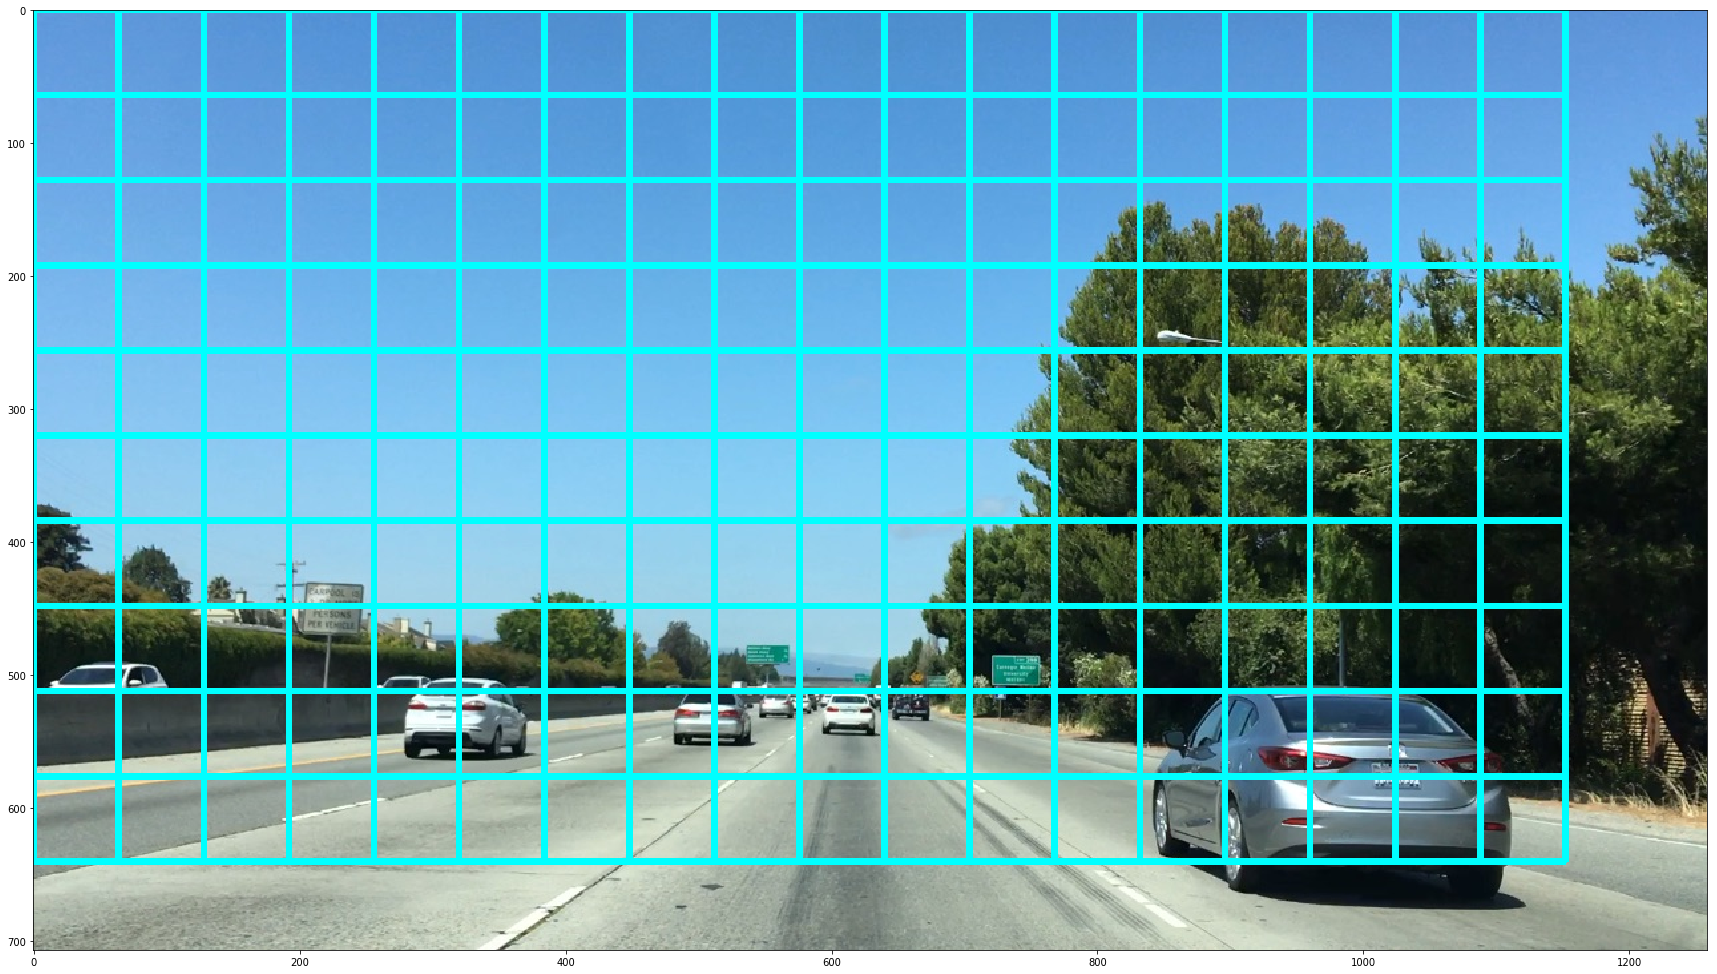

In [11]:
r, c, n = test_img.shape
windows = create_windows(x_region=[0, c], y_region=[0, r], xy_window=(64, 64), xy_overlap=(0, 0))
print"Number of windows: ", len(windows)

# Draw image
draw_img = np.copy(test_img)
draw_img = draw_boxes(draw_img, windows, color=(0, 255, 255), thick=3)

a = plt.figure( figsize =(30, 20))
plt.imshow(draw_img)

In [13]:
from utils import draw_windows
from utils import CameraCalibrator, ProjectionManager, LineTracker, ImageFilter, DiagnosticMgr

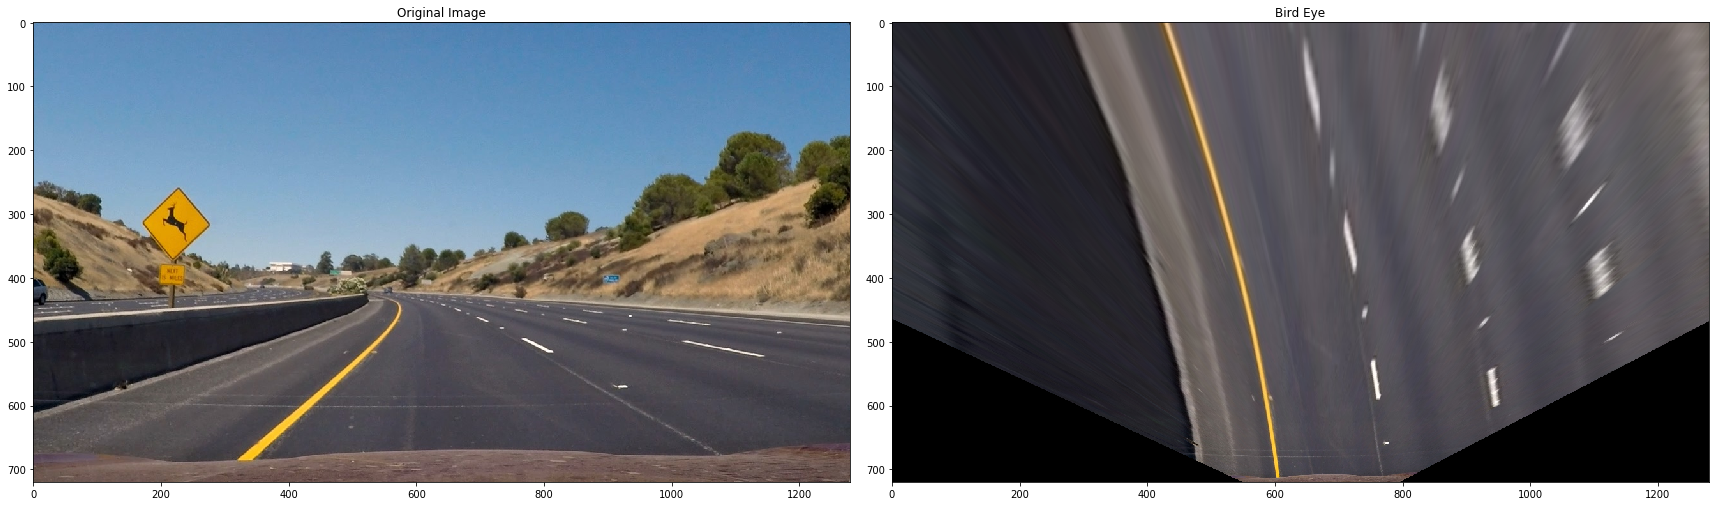

In [26]:
# Try different approach in Project 4
frame = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
r, w, c = frame.shape


img_filter = ImageFilter((r, w))
projmgr = ProjectionManager(cam_calib=None, row=r, col=w,src=None, dst=None, offset=370)

undst_img = frame
bin_img = img_filter.mix_color_grad_thresh(undst_img, s_thresh=(88, 255),  h_thresh=(150, 255), grad_thresh=(60, 150))
bin_img = img_filter.region_of_interest(bin_img, projmgr.get_roi())  # FOcus on ROI only.

# Perspective Transform
binary_roi = img_filter.region_of_interest(bin_img, projmgr.get_roi())
birdseye_view = projmgr.get_birdeye_view(undst_img)
birdseye_img = projmgr.get_birdeye_view(binary_roi)

# # Sliding window
# window_centroids = curve_centers.find_lane_line(warped=birdseye_img)
# windows, left_x, right_x = draw_windows(birdseye_img, w=25, h=80, window_centroids=window_centroids)

# # Curve-fit and calculate curvature and offset
# curved_fit, curvature, offset = curve_centers.curve_fit(windows, left_x, right_x)

# # Convert back to normal vieward
# lane_lines = projmgr.get_normal_view(curved_fit)

# # Merge to original image
# lane_lines = cv2.addWeighted(undst_img, 1.0, lane_lines, 0.5, 0.0)

f, ax = plt.subplots(1, 2, figsize =(24,9))
f.tight_layout()
ax[0].imshow(frame)
ax[0].set_title('Original Image')
ax[1].imshow(birdseye_view)
ax[1].set_title('Bird Eye')

In [ ]:
# Create a series of orthogonal lines in each lane. In order to find a diagonal line, we use the curve fit function
# to find the angle to the lines compared to lane
def create_lines(img, leftx, rightx, width=None, angle=45, density=30):
    